<a href="https://colab.research.google.com/github/tazeemc/options/blob/main/Everlasting_Options_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn
import pandas as pd
from matplotlib.pyplot import figure
from itertools import cycle, islice

# Put Payoff

In [ ]:
strike = 3000
vol = 1
spot = np.arange(2750., 3250., 10.)
payoff = np.maximum(strike - spot, 0)

Text(0.5, 1.0, 'Put Payoff vs. Spot Price (3000 strike)')

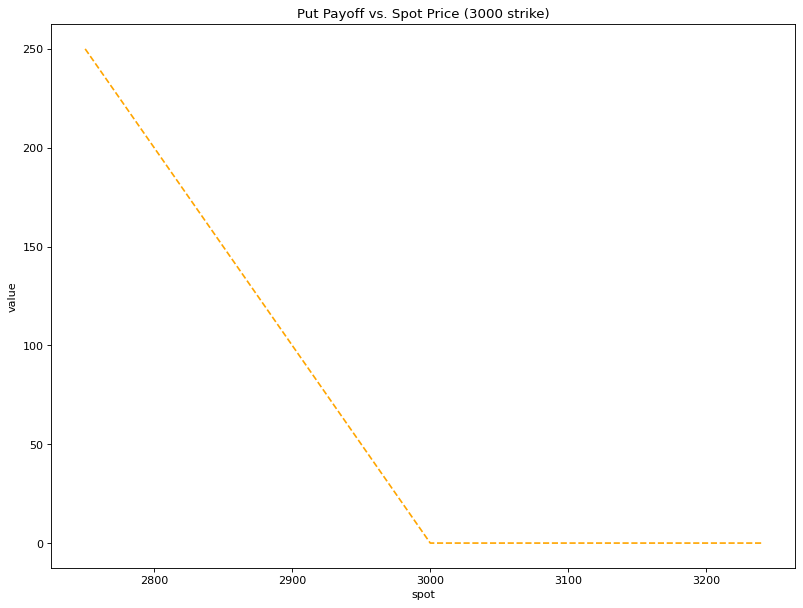

In [ ]:
data = pd.DataFrame({'spot': spot, 'payoff': payoff}).set_index('spot')

figure(figsize=(12, 9), dpi=80)
ax = sbn.lineplot(data=data, legend=False)
ax.set_ylabel("value")
ax.lines[0].set_linestyle("--")
ax.lines[0].set_color("orange")
ax.set_title("Put Payoff vs. Spot Price (3000 strike)")

# Black Scholes Option Price

In [ ]:
# from https://numba.pydata.org/numba-examples/examples/finance/blackscholes/results.html
def cnd(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * np.abs(d))
    ret_val = (RSQRT2PI * np.exp(-0.5 * d * d) *
               (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5))))))
    return np.where(d > 0, 1.0 - ret_val, ret_val)

    # SPEEDTIP: Despite the memory overhead and redundant computation, the above
    # is much faster than:
    #
    # for i in range(len(d)):
    #     if d[i] > 0:
    #         ret_val[i] = 1.0 - ret_val[i]
    # return ret_val


def black_scholes(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT
    cndd1 = cnd(d1)
    cndd2 = cnd(d2)

    expRT = np.exp(- R * T)

    callResult = S * cndd1 - X * expRT * cndd2
    putResult = X * expRT * (1.0 - cndd2) - S * (1.0 - cndd1)

    return callResult, putResult

Text(0.5, 1.0, 'Put Price vs. Spot Price (3000 strike, 100 vol)')

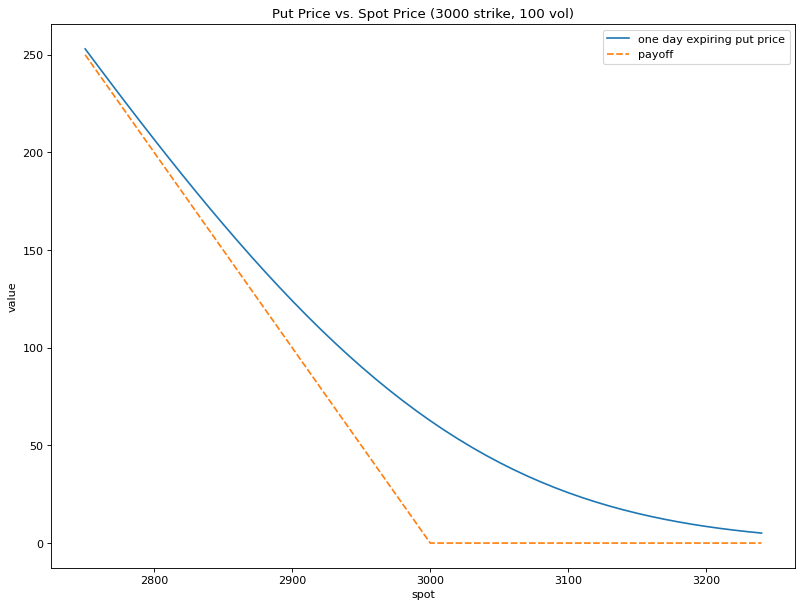

In [ ]:
_, one_day_put_price = black_scholes(spot, strike, 1.0/365, 0,vol)
data = pd.DataFrame({'spot': spot, 'one day expiring put price': one_day_put_price, 'payoff': payoff}).set_index('spot')
figure(figsize=(12, 9), dpi=80)
ax = sbn.lineplot(data=data)
ax.set_ylabel("value")
ax.set_title("Put Price vs. Spot Price (3000 strike, 100 vol)")

In [ ]:
def everlasting_put_price(spot, strike, vol, funding_period_days):
  one_day = 1.0/365
  num_fundings = np.arange(1.0, 21.0, 1.0)

  expo = one_day * num_fundings * funding_period_days
  
  _, put_px  = black_scholes(spot, strike, expo, 0, vol)

  weight = 1/2 ** num_fundings
  
  return np.sum(weight * put_px)

Text(0.5, 1.0, 'Put Price vs. Spot Price (3000 strike, 100 vol)')

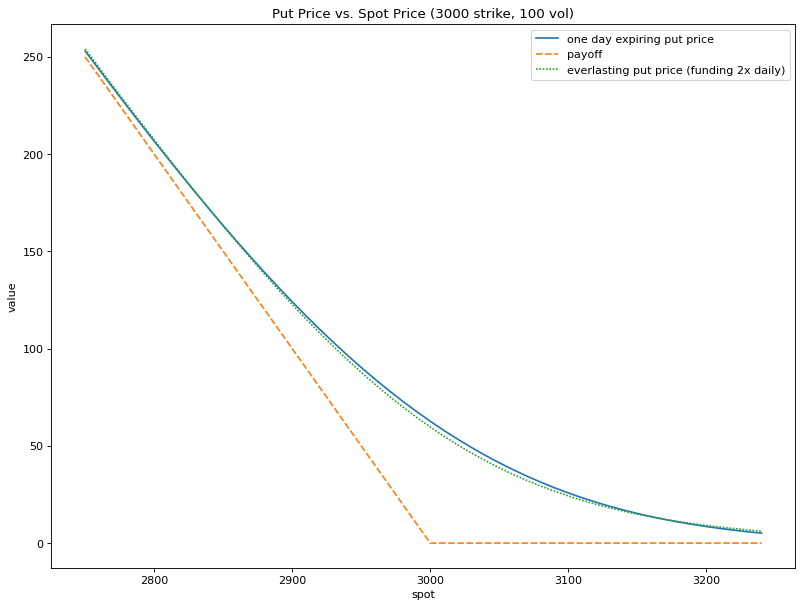

In [ ]:
funding_period_days = 0.5
ever_price = [everlasting_put_price(x, strike, vol, funding_period_days) for x in spot]
_, one_day_put_price = black_scholes(spot, strike, 1.0/365, 0,vol)
data = pd.DataFrame({'spot': spot, 'one day expiring put price': one_day_put_price, 'payoff': payoff, 'everlasting put price (funding 2x daily)' : ever_price,}).set_index('spot')
figure(figsize=(12, 9), dpi=80)
ax = sbn.lineplot(data=data)
ax.set_ylabel("value")
ax.set_title("Put Price vs. Spot Price (3000 strike, 100 vol)")

# Portfolio Composition

In [ ]:
expos = np.arange(10)

comp_pre = 1.0 / 2 ** (expos+1)


remaining = np.copy(comp_pre)
remaining[0] = 0

will_expire = np.zeros(10)
will_expire[0] = 0.5

init_df = pd.DataFrame({'will remain after funding (.5 contracts total)' : remaining,
                        'will expire at funding (.5 contracts total)' : will_expire},
                  index = expos)

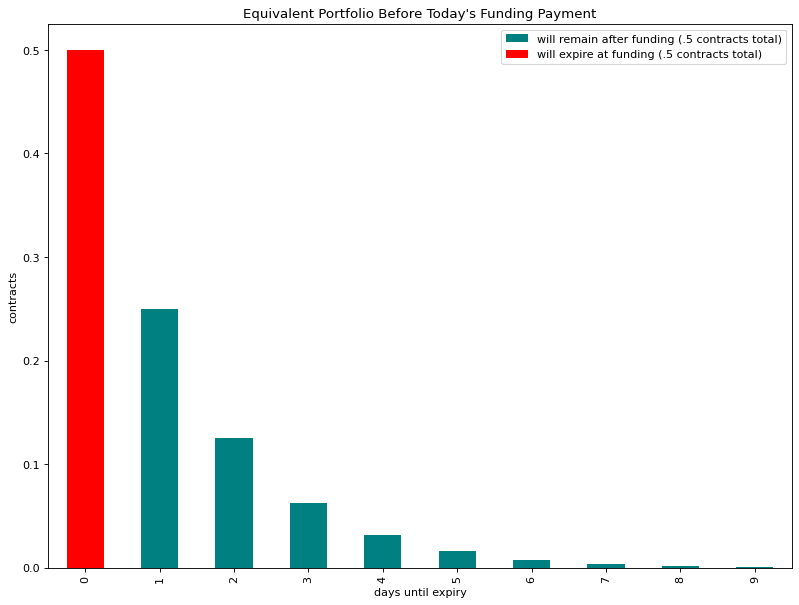

In [ ]:
my_colors = list(islice(cycle(['teal', 'r']), None, len(df)))
init_df.plot(kind="bar",
             title="Equivalent Portfolio Before Today's Funding Payment",
             ylabel = "contracts",
             xlabel = "days until expiry",
             color = my_colors,
             stacked=True,
            figsize = (12, 9))

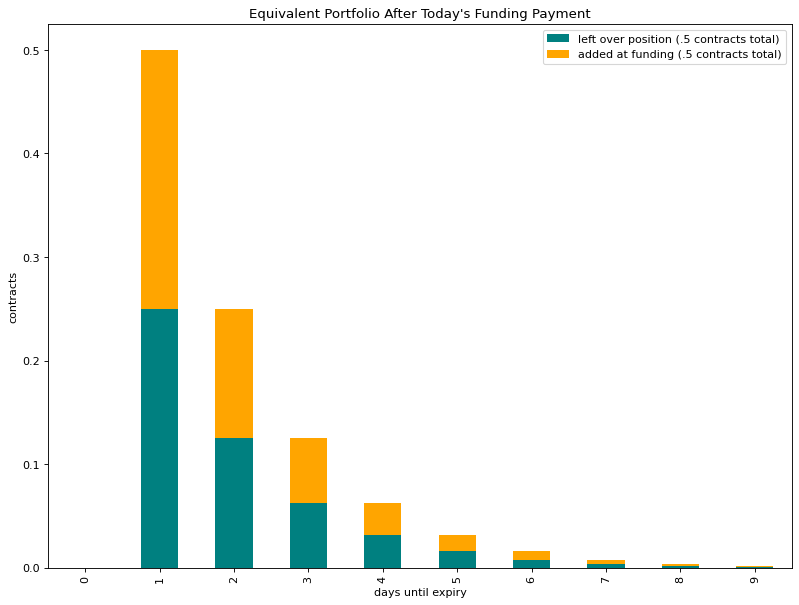

In [ ]:
added = np.copy(remaining)

after_df = pd.DataFrame({
                   'left over position (.5 contracts total)' : remaining,
                   'added at funding (.5 contracts total)' : added}, 
                  index = expos)
my_colors = list(islice(cycle(['teal', 'orange']), None, len(df)))
after_df.plot(kind="bar",
             title="Equivalent Portfolio After Today's Funding Payment",
             ylabel = "contracts",
             xlabel = "days until expiry",
             stacked=True,
              color = my_colors,
            figsize = (12, 9))